<img src=https://i.ibb.co/wJW61Y2/Used-cars.jpg width="700" height="200">

## <p style="background-color:#FDFEFE; font-family:newtimeroman; color:#060108; font-size:200%; text-align:center; border-radius:10px 10px;">The Capstone Project of Data Analytics Module</p>

## <p style="background-color:#FDFEFE; font-family:newtimeroman; color:#060108; font-size:150%; text-align:center; border-radius:10px 10px;">Car Price Prediction EDA</p>

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from scipy import stats
from scipy.stats.mstats import winsorize

import warnings
warnings.filterwarnings('ignore')
warnings.warn("this will not show")

%matplotlib inline
# %matplotlib notebook

plt.rcParams["figure.figsize"] = (10, 6)
# plt.rcParams['figure.dpi'] = 100

sns.set_style("whitegrid")
pd.set_option('display.float_format', lambda x: '%.3f' % x)

pd.options.display.max_rows = 1000
pd.options.display.max_columns = 150

In [30]:
# function for first looking to the columns

def first_looking(col):
    print("column name    : ", col)
    print("--------------------------------")
    print("per_of_nulls   : ", "%", round(df[col].isnull().sum()*100 / df.shape[0], 2))
    print("num_of_nulls   : ", df[col].isnull().sum())
    print("num_of_uniques : ", df[col].nunique())
    print("--------------------------------")
    print(df[col].value_counts(dropna = False))

## functions to fill the missing values

In [31]:
def fill_most(df, group_col, col_name):
    '''Fills the missing values with the most existing value (mode) in the relevant column according to single-stage grouping'''
    for group in list(df[group_col].unique()):
        cond = df[group_col]==group
        mode = list(df[cond][col_name].mode())
        if mode != []:
            df.loc[cond, col_name] = df.loc[cond, col_name].fillna(df[cond][col_name].mode()[0])
        else:
            df.loc[cond, col_name] = df.loc[cond, col_name].fillna(df[col_name].mode()[0])
    print("Number of NaN : ", df[col_name].isnull().sum())
    print("------------------")
    print(df[col_name].value_counts(dropna=False))

In [32]:
def fill_prop(df, group_col, col_name):
    for group in list(df[group_col].unique()):
        cond = df[group_col]==group
        df.loc[cond, col_name] = df.loc[cond, col_name].fillna(method="ffill").fillna(method="bfill")
    df[col_name] = df[col_name].fillna(method="ffill").fillna(method="bfill")
    print("Number of NaN : ", df[col_name].isnull().sum())
    print("------------------")
    print(df[col_name].value_counts(dropna=False))

In [33]:
def fill(df, group_col1, group_col2, col_name, method): # method can be either "mode" or "mean" or "median" or "ffill"
    
    '''Fills the missing values with "mode/mean/median/ffill/bfill method" according to double-stage grouping'''
    
    if method == "mode":
        for group1 in list(df[group_col1].unique()):
            for group2 in list(df[group_col2].unique()):
                cond1 = df[group_col1]==group1
                cond2 = (df[group_col1]==group1) & (df[group_col2]==group2)
                mode1 = list(df[cond1][col_name].mode())
                mode2 = list(df[cond2][col_name].mode())
                if mode2 != []:
                    df.loc[cond2, col_name] = df.loc[cond2, col_name].fillna(df[cond2][col_name].mode()[0])
                elif mode1 != []:
                    df.loc[cond2, col_name] = df.loc[cond2, col_name].fillna(df[cond1][col_name].mode()[0])
                else:
                    df.loc[cond2, col_name] = df.loc[cond2, col_name].fillna(df[col_name].mode()[0])

    elif method == "mean":
        df[col_name].fillna(df.groupby([group_col1, group_col2])[col_name].transform("mean"), inplace = True)
        df[col_name].fillna(df.groupby(group_col1)[col_name].transform("mean"), inplace = True)
        df[col_name].fillna(df[col_name].mean(), inplace = True)
        
    elif method == "median":
        df[col_name].fillna(df.groupby([group_col1, group_col2])[col_name].transform("median"), inplace = True)
        df[col_name].fillna(df.groupby(group_col1)[col_name].transform("median"), inplace = True)
        df[col_name].fillna(df[col_name].median(), inplace = True)
        
    elif method == "ffill":           
        for group1 in list(df[group_col1].unique()):
            for group2 in list(df[group_col2].unique()):
                cond2 = (df[group_col1]==group1) & (df[group_col2]==group2)
                df.loc[cond2, col_name] = df.loc[cond2, col_name].fillna(method="ffill").fillna(method="bfill")
                
        for group1 in list(df[group_col1].unique()):
            cond1 = df[group_col1]==group1
            df.loc[cond1, col_name] = df.loc[cond1, col_name].fillna(method="ffill").fillna(method="bfill")            
           
        df[col_name] = df[col_name].fillna(method="ffill").fillna(method="bfill")
    
    print("Number of NaN : ",df[col_name].isnull().sum())
    print("------------------")
    print(df[col_name].value_counts(dropna=False))

## <p style="background-color:#9d4f8c; font-family:newtimeroman; color:#FFF9ED; font-size:175%; text-align:center; border-radius:10px 10px;">PART - 03 (Handling with Outliers)</p>

<a id="1"></a>
<a href="#toc" class="btn btn-primary btn-sm" role="button" aria-pressed="true" 
style="color:blue; background-color:#dfa8e4" data-toggle="popover">Content</a>

In [34]:
df = pd.read_csv("filled_scout.csv")

In [35]:
df.shape

(15919, 26)

In [36]:
df.head(3).T

,0,1,2
make_model,Audi A1,Audi A1,Audi A1
body_type,Sedans,Sedans,Sedans
price,15770,14500,14640
vat,VAT deductible,Price negotiable,VAT deductible
km,56013.000,80000.000,83450.000
Type,Used,Used,Used
Fuel,Diesel,Benzine,Diesel
Comfort_Convenience,"Air conditioning,Armrest,Automatic climate con...","Air conditioning,Automatic climate control,Hil...","Air conditioning,Cruise control,Electrical sid..."
Entertainment_Media,"Bluetooth,Hands-free equipment,On-board comput...","Bluetooth,Hands-free equipment,On-board comput...","MP3,On-board computer"
Extras,"Alloy wheels,Catalytic Converter,Voice Control","Alloy wheels,Sport seats,Sport suspension,Voic...","Alloy wheels,Voice Control"


## <p style="background-color:#9d4f8c; font-family:newtimeroman; color:#FFF9ED; font-size:175%; text-align:center; border-radius:10px 10px;">The Examination of OUTLIERS in the Columns</p>

<a id="2"></a>
<a href="#toc" class="btn btn-primary btn-sm" role="button" aria-pressed="true" 
style="color:blue; background-color:#dfa8e4" data-toggle="popover">Content</a>

## km

In [37]:
first_looking("km")

column name    :  km
--------------------------------
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  6692
--------------------------------
10.000       1045
1647.363      985
1.000         367
5.000         170
50.000        148
             ... 
67469.000       1
43197.000       1
10027.000       1
35882.000       1
57.000          1
Name: km, Length: 6692, dtype: int64


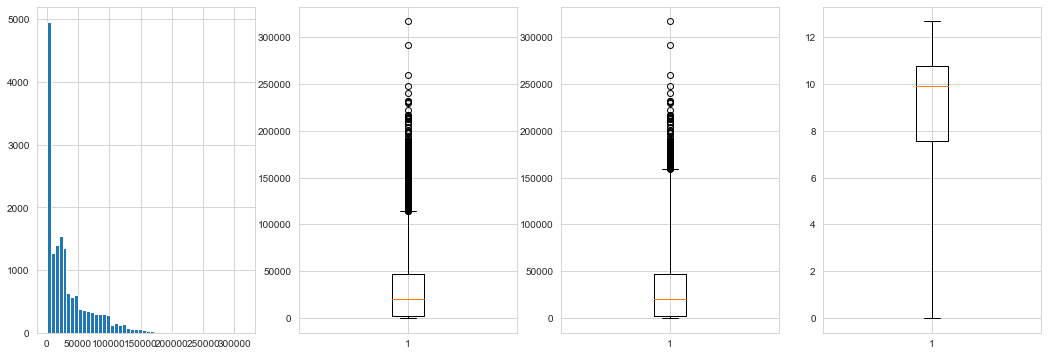

In [38]:
plt.figure(figsize=(18, 6))

plt.subplot(141)
plt.hist(df.km, bins=50)

plt.subplot(142)
plt.boxplot(df.km)

plt.subplot(143)
plt.boxplot(df.km, whis=2.5)

plt.subplot(144)
plt.boxplot(np.log(df.km), whis=2.5)

plt.show()

In [39]:
#df["km_logged"] = np.log(df.km)

**``km``** **is a variable with a wide range of values. We CANNOT consider the extreme values above as  genuine outliers. So let's keep these extreme values as they are.**

## Gears

In [40]:
first_looking("Gears")

column name    :  Gears
--------------------------------
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  10
--------------------------------
6.000     8615
5.000     4255
7.000     2810
8.000      225
9.000        6
1.000        2
3.000        2
4.000        2
2.000        1
50.000       1
Name: Gears, dtype: int64


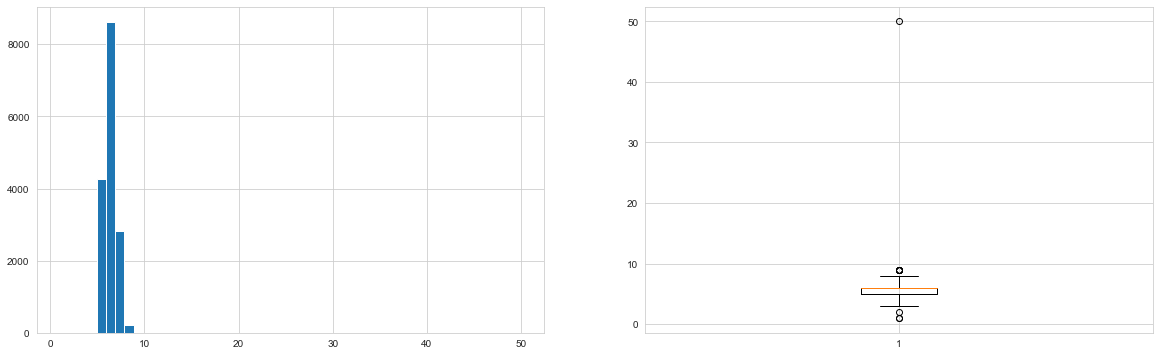

In [41]:
plt.figure(figsize=(20, 6))

plt.subplot(121)
plt.hist(df.Gears, bins=50)

plt.subplot(122)
plt.boxplot(df.Gears, whis=2.5)

plt.show()

In [42]:
df.Gears.describe()

count   15919.000
mean        5.940
std         0.792
min         1.000
25%         5.000
50%         6.000
75%         6.000
max        50.000
Name: Gears, dtype: float64

In [43]:
df.sort_values(by=["Gears"], ascending=False)["Gears"].head(10)

14495   50.000
15827    9.000
15824    9.000
15814    9.000
15869    9.000
15812    9.000
15876    9.000
12463    8.000
12470    8.000
12469    8.000
Name: Gears, dtype: float64

In [44]:
df.sort_values(by=["Gears"], ascending=True)["Gears"].head(10)

8921    1.000
14375   1.000
9812    2.000
15817   3.000
15845   3.000
15823   4.000
15822   4.000
10427   5.000
10428   5.000
10429   5.000
Name: Gears, dtype: float64

In [45]:
# Let's check the observations having extreme Gear value.  
df[(df.Gears < 5) | (df.Gears > 8)][["make_model", "body_type", "Gearing_Type", "Gears"]]

,make_model,body_type,Gearing_Type,Gears
8921,Opel Corsa,Compact,Semi-automatic,1.000
9812,Opel Corsa,Sedans,Manual,2.000
14375,Renault Clio,Compact,Automatic,1.000
14495,Renault Clio,Sedans,Manual,50.000
15812,Renault Espace,Van,Automatic,9.000
15814,Renault Espace,Van,Automatic,9.000
15817,Renault Espace,Van,Automatic,3.000
15822,Renault Espace,Van,Automatic,4.000
15823,Renault Espace,Van,Automatic,4.000
15824,Renault Espace,Van,Automatic,9.000


In [47]:
# Let's check the observations belongs to "Renault Espace" model to see distribution of Gear values.  
df[(df.make_model == "Renault Espace")][["make_model", "body_type", "Gearing_Type", "Gears"]]

,make_model,body_type,Gearing_Type,Gears
14928,Renault Espace,Van,Automatic,6.000
14929,Renault Espace,Station wagon,Automatic,6.000
14930,Renault Espace,Transporter,Automatic,6.000
14931,Renault Espace,Van,Automatic,6.000
14932,Renault Espace,Van,Automatic,6.000
14933,Renault Espace,Transporter,Automatic,6.000
14934,Renault Espace,Van,Automatic,6.000
14935,Renault Espace,Van,Automatic,6.000
14936,Renault Espace,Off-Road,Automatic,6.000
14937,Renault Espace,Van,Automatic,6.000


In [48]:
df["Gears"].replace([1, 2, 3, 4, 9, 50], np.nan, inplace=True)

In [49]:
df.Gears.isnull().sum()

14

In [50]:
fill(df, "make_model", "body_type", "Gears", "mode")

Number of NaN :  0
------------------
6.000    8625
5.000    4259
7.000    2810
8.000     225
Name: Gears, dtype: int64


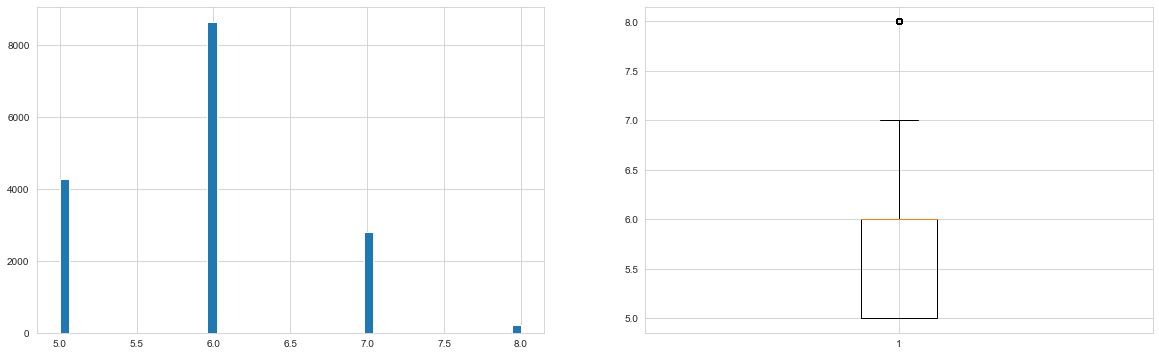

In [51]:
plt.figure(figsize=(20, 6))

plt.subplot(121)
plt.hist(df.Gears, bins=50)

plt.subplot(122)
plt.boxplot(df.Gears, whis=1.5)

plt.show()

## displacement_cc

In [52]:
first_looking("Displacement_cc")

column name    :  Displacement_cc
--------------------------------
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  77
--------------------------------
1598.000     5044
999.000      2467
1398.000     1387
1399.000      768
1229.000      678
1956.000      670
1461.000      667
1490.000      559
1422.000      467
1197.000      372
898.000       351
1395.000      320
1968.000      301
1149.000      288
1618.000      212
1798.000      210
1498.000      196
1600.000      130
1248.000      110
1997.000      103
1364.000      102
1400.000       90
998.000        72
1500.000       50
2000.000       46
1000.000       40
1.000          36
1998.000       25
2480.000       20
1200.000       18
1984.000       18
1397.000       11
899.000        11
160.000         6
929.000         5
1499.000        5
997.000         4
1596.000        4
139.000         4
900.000         4
1599.000        3
1199.000        3
1396.000        3
1495.000        2
1589.000        2
1300.000        2
2.000  

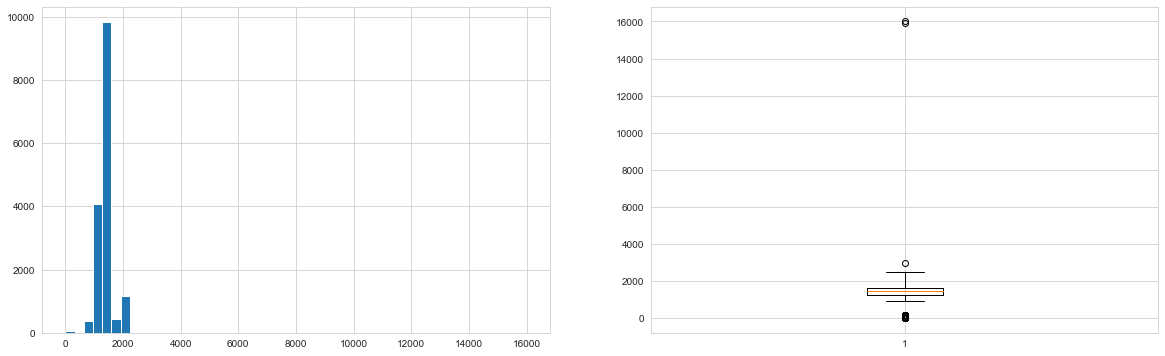

In [53]:
plt.figure(figsize=(20, 6))

plt.subplot(121)
plt.hist(df.Displacement_cc, bins=50)

plt.subplot(122)
plt.boxplot(df.Displacement_cc, whis=2.5)

plt.show()

In [54]:
df.Displacement_cc.describe()

count   15919.000
mean     1425.609
std       329.720
min         1.000
25%      1229.000
50%      1461.000
75%      1598.000
max     16000.000
Name: Displacement_cc, dtype: float64

In [55]:
df.sort_values(by=["Displacement_cc"], ascending=False)["Displacement_cc"].head(5)

10932   16000.000
7169    15898.000
10771    2967.000
3595     2480.000
3587     2480.000
Name: Displacement_cc, dtype: float64

In [56]:
df.sort_values(by=["Displacement_cc"], ascending=True)["Displacement_cc"].head(55)

12790     1.000
14319     1.000
14315     1.000
12849     1.000
12848     1.000
12835     1.000
12823     1.000
12815     1.000
12800     1.000
12798     1.000
12796     1.000
12786     1.000
12783     1.000
12781     1.000
12769     1.000
12768     1.000
12750     1.000
12670     1.000
12604     1.000
12554     1.000
12501     1.000
12499     1.000
12484     1.000
12473     1.000
12467     1.000
14284     1.000
14320     1.000
14321     1.000
14314     1.000
14322     1.000
14328     1.000
14327     1.000
13904     1.000
14325     1.000
14326     1.000
14324     1.000
10559     2.000
14198     2.000
13912    54.000
10194   122.000
7810    139.000
7812    139.000
7811    139.000
7809    139.000
8128    140.000
15578   160.000
15576   160.000
15574   160.000
15575   160.000
15577   160.000
15579   160.000
13653   890.000
14694   898.000
14342   898.000
14695   898.000
Name: Displacement_cc, dtype: float64

In [57]:
outlier_bool_list = df.Displacement_cc.isin([1, 2, 54, 122, 139, 140, 160, 16000, 15898])

In [58]:
outlier_bool_list

0        False
1        False
2        False
3        False
4        False
         ...  
15914    False
15915    False
15916    False
15917    False
15918    False
Name: Displacement_cc, Length: 15919, dtype: bool

In [59]:
df.loc[outlier_bool_list, "Displacement_cc"] = np.nan

In [60]:
df.Displacement_cc.isnull().sum()

53

In [61]:
fill(df, "make_model", "body_type", "Displacement_cc", "mode")

Number of NaN :  0
------------------
1598.000    5077
999.000     2467
1398.000    1388
1399.000     772
1461.000     682
1229.000     678
1956.000     670
1490.000     559
1422.000     467
1197.000     372
898.000      351
1395.000     320
1968.000     301
1149.000     288
1618.000     212
1798.000     210
1498.000     196
1600.000     130
1248.000     110
1997.000     103
1364.000     102
1400.000      90
998.000       72
1500.000      50
2000.000      46
1000.000      40
1998.000      25
2480.000      20
1984.000      18
1200.000      18
1397.000      11
899.000       11
929.000        5
1499.000       5
997.000        4
900.000        4
1596.000       4
1599.000       3
1396.000       3
1199.000       3
1589.000       2
1300.000       2
1495.000       2
995.000        2
890.000        1
1333.000       1
1580.000       1
1995.000       1
1533.000       1
1100.000       1
1198.000       1
1496.000       1
1368.000       1
1896.000       1
1584.000       1
1568.000       1
996.000   

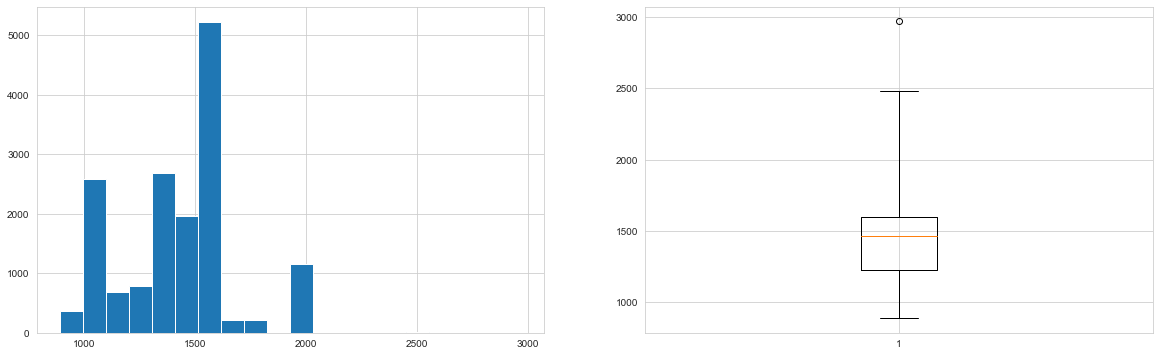

In [62]:
plt.figure(figsize=(20, 6))

plt.subplot(121)
plt.hist(df.Displacement_cc, bins=20)

plt.subplot(122)
plt.boxplot(df.Displacement_cc, whis=2.5)

plt.show()

## Weight_kg

In [63]:
first_looking("Weight_kg")

column name    :  Weight_kg
--------------------------------
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  434
--------------------------------
1163.000    1582
1360.000    1419
1487.000     966
1135.000     837
1425.000     744
1180.000     694
1273.000     656
1165.000     603
1503.000     561
1734.000     556
1087.000     291
1335.000     242
1365.000     211
1199.000     205
1350.000     156
1119.000     153
1355.000     136
1260.000     127
1280.000     127
1275.000     112
1278.000     110
1255.000     108
1200.000     107
1522.000     103
1659.000     102
1195.000      96
1120.000      93
1403.000      91
1701.000      87
1250.000      85
1685.000      83
1441.000      82
1308.000      80
1285.000      80
1613.000      75
1110.000      75
1279.000      72
1364.000      70
1345.000      67
1733.000      65
1325.000      64
1141.000      64
1209.000      64
1071.000      64
1230.000      63
1845.000      56
1090.000      54
1052.000      53
1154.000      52
1664.00

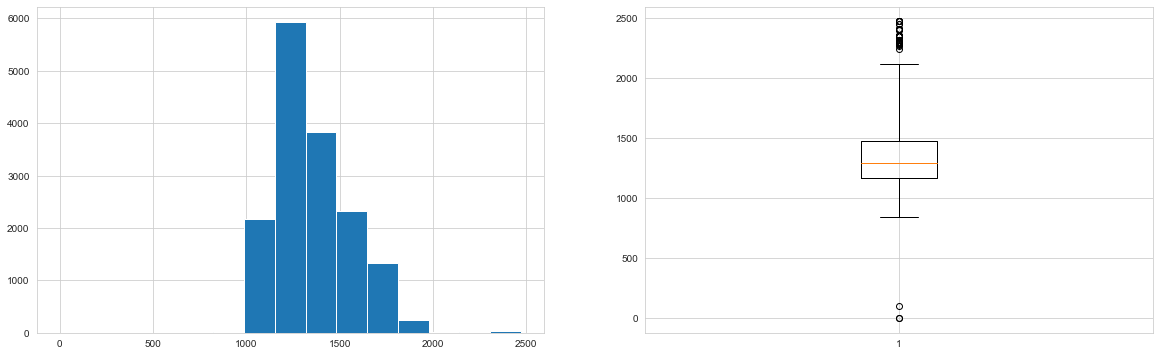

In [64]:
plt.figure(figsize=(20, 6))

plt.subplot(121)
plt.hist(df.Weight_kg, bins=15)

plt.subplot(122)
plt.boxplot(df.Weight_kg, whis=2.5)

plt.show()

In [65]:
df.Weight_kg.describe()

count   15919.000
mean     1337.432
std       200.466
min         1.000
25%      1165.000
50%      1295.000
75%      1472.000
max      2471.000
Name: Weight_kg, dtype: float64

In [66]:
df["Weight_kg"].sort_values().head(10)

8355      1.000
12779     1.000
1143    102.000
8857    840.000
14313   900.000
13513   977.000
13555   977.000
14654   980.000
14105   980.000
13999   980.000
Name: Weight_kg, dtype: float64

In [67]:
df["Weight_kg"].replace([1, 102], np.nan, inplace = True)

In [68]:
df["Weight_kg"].isnull().sum()

3

In [69]:
fill(df, "make_model", "body_type", "Weight_kg", "mode")

Number of NaN :  0
------------------
1163.000    1583
1360.000    1419
1487.000     967
1135.000     837
1425.000     744
1180.000     695
1273.000     656
1165.000     603
1503.000     561
1734.000     556
1087.000     291
1335.000     242
1365.000     211
1199.000     205
1350.000     156
1119.000     153
1355.000     136
1280.000     127
1260.000     127
1275.000     112
1278.000     110
1255.000     108
1200.000     107
1522.000     103
1659.000     102
1195.000      96
1120.000      93
1403.000      91
1701.000      87
1250.000      85
1685.000      83
1441.000      82
1308.000      80
1285.000      80
1613.000      75
1110.000      75
1279.000      72
1364.000      70
1345.000      67
1733.000      65
1071.000      64
1141.000      64
1209.000      64
1325.000      64
1230.000      63
1845.000      56
1090.000      54
1052.000      53
1154.000      52
1664.000      52
1513.000      51
1065.000      50
1237.000      49
1440.000      46
1205.000      46
1088.000      46
1265.000  

In [70]:
df["Weight_kg"].isnull().sum()

0

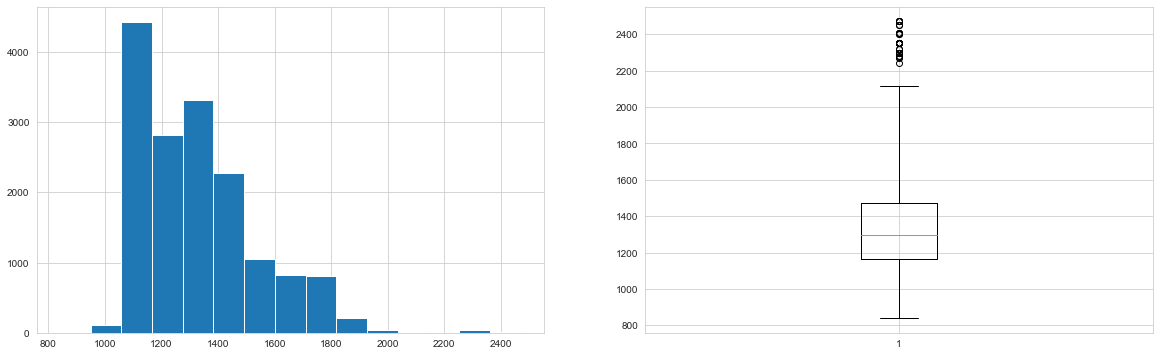

In [71]:
plt.figure(figsize=(20, 6))

plt.subplot(121)
plt.hist(df.Weight_kg, bins=15)

plt.subplot(122)
plt.boxplot(df.Weight_kg, whis=2.5)

plt.show()

## hp_kW

In [72]:
first_looking("hp_kW")

column name    :  hp_kW
--------------------------------
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  80
--------------------------------
85.000     2543
66.000     2124
81.000     1403
100.000    1314
110.000    1113
70.000      890
125.000     711
51.000      696
55.000      589
118.000     550
92.000      466
121.000     392
147.000     380
77.000      353
56.000      294
54.000      276
103.000     253
87.000      232
165.000     194
88.000      177
60.000      160
162.000      98
74.000       81
96.000       72
71.000       59
101.000      47
67.000       40
154.000      39
122.000      35
119.000      30
164.000      27
135.000      24
52.000       22
82.000       22
1.000        20
78.000       20
294.000      18
146.000      18
141.000      16
57.000       10
120.000       8
104.000       8
112.000       7
191.000       7
155.000       6
117.000       6
184.000       5
65.000        4
90.000        4
76.000        4
168.000       3
98.000        3
149.000      

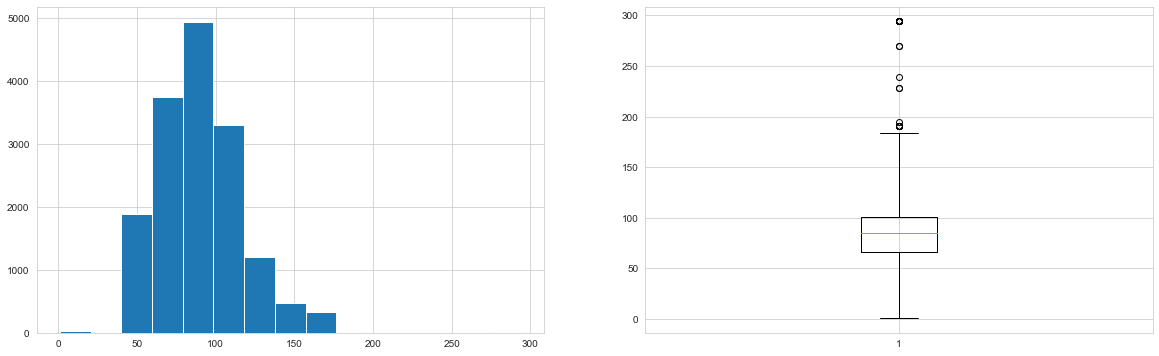

In [73]:
plt.figure(figsize=(20, 6))

plt.subplot(121)
plt.hist(df.hp_kW, bins=15)

plt.subplot(122)
plt.boxplot(df.hp_kW, whis=2.5)

plt.show()

In [74]:
df.hp_kW.describe()

count   15919.000
mean       88.374
std        26.844
min         1.000
25%        66.000
50%        85.000
75%       101.000
max       294.000
Name: hp_kW, dtype: float64

In [75]:
df.hp_kW.sort_values().head(50)

6034     1.000
6946     1.000
7014     1.000
9285     1.000
9287     1.000
6005     1.000
9288     1.000
7018     1.000
9289     1.000
9290     1.000
9292     1.000
9299     1.000
10610    1.000
10580    1.000
10579    1.000
10468    1.000
15155    1.000
15156    1.000
7019     1.000
7016     1.000
13885    4.000
3913     9.000
8857    40.000
13759   40.000
8408    44.000
10282   51.000
10283   51.000
10284   51.000
10285   51.000
10286   51.000
10287   51.000
9145    51.000
10288   51.000
10346   51.000
10281   51.000
10330   51.000
9026    51.000
9025    51.000
10342   51.000
10289   51.000
9159    51.000
9384    51.000
9158    51.000
10290   51.000
10291   51.000
10345   51.000
10280   51.000
10279   51.000
10278   51.000
10264   51.000
Name: hp_kW, dtype: float64

In [76]:
np.sort(df.hp_kW.unique())

array([  1.,   4.,   9.,  40.,  44.,  51.,  52.,  53.,  54.,  55.,  56.,
        57.,  60.,  63.,  65.,  66.,  67.,  70.,  71.,  74.,  75.,  76.,
        77.,  78.,  80.,  81.,  82.,  84.,  85.,  86.,  87.,  88.,  89.,
        90.,  92.,  93.,  96.,  98., 100., 101., 103., 104., 110., 112.,
       115., 117., 118., 119., 120., 121., 122., 123., 125., 127., 132.,
       133., 135., 137., 140., 141., 143., 146., 147., 149., 150., 154.,
       155., 162., 163., 164., 165., 167., 168., 184., 191., 195., 228.,
       239., 270., 294.])

In [77]:
df.hp_kW.loc[df.hp_kW < 40] = np.nan

In [78]:
df.hp_kW.isnull().sum()

22

In [79]:
fill(df, "make_model", "body_type", "hp_kW", "mode")

Number of NaN :  0
------------------
85.000     2544
66.000     2124
81.000     1403
100.000    1317
110.000    1117
70.000      890
125.000     715
51.000      703
55.000      589
118.000     552
92.000      466
121.000     392
147.000     380
77.000      353
56.000      295
54.000      276
103.000     253
87.000      232
165.000     194
88.000      177
60.000      160
162.000      98
74.000       81
96.000       72
71.000       59
101.000      47
67.000       40
154.000      39
122.000      35
119.000      30
164.000      27
135.000      24
52.000       22
82.000       22
78.000       20
294.000      18
146.000      18
141.000      16
57.000       10
120.000       8
104.000       8
112.000       7
191.000       7
155.000       6
117.000       6
184.000       5
65.000        4
76.000        4
90.000        4
98.000        3
168.000       3
149.000       3
80.000        3
93.000        3
143.000       2
86.000        2
140.000       2
150.000       2
228.000       2
270.000       2
53

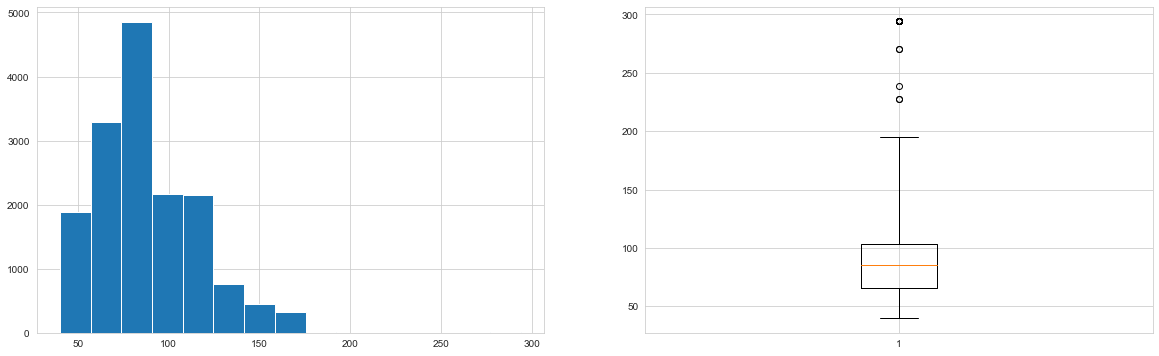

In [80]:
plt.figure(figsize=(20, 6))

plt.subplot(121)
plt.hist(df.hp_kW, bins=15)

plt.subplot(122)
plt.boxplot(df.hp_kW, whis=2.5)

plt.show()

## CO2_Emission

In [81]:
first_looking("CO2_Emission")

column name    :  CO2_Emission
--------------------------------
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  124
--------------------------------
120.000      836
119.000      714
102.000      694
104.000      679
106.000      623
114.000      555
99.000       545
97.000       538
139.000      523
124.000      516
103.000      445
107.000      413
108.000      362
125.000      344
129.000      333
128.000      331
133.000      330
118.000      315
110.000      289
126.000      282
85.000       275
127.000      257
117.000      254
111.000      237
113.000      235
109.000      234
140.000      221
105.000      202
135.000      202
92.000       198
130.000      189
123.000      186
150.000      174
143.000      171
112.000      171
95.000       161
116.000      157
141.000      156
98.000       151
136.000      145
137.000      133
134.000      130
145.000      126
149.000      117
153.000      113
147.000      109
101.000      105
132.000      100
115.000       86
122.

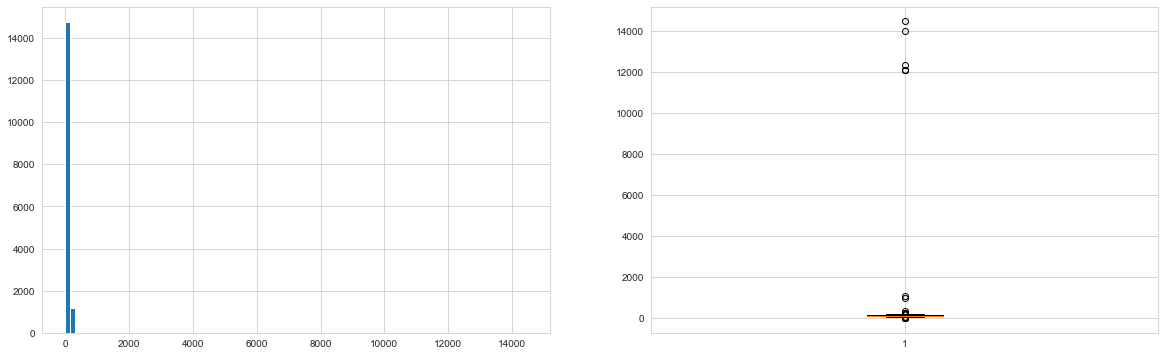

In [82]:
plt.figure(figsize=(20, 6))

plt.subplot(121)
plt.hist(df.CO2_Emission, bins=100)

plt.subplot(122)
plt.boxplot(df.CO2_Emission, whis=2.5)

plt.show()

In [83]:
df.CO2_Emission.describe()

count   15919.000
mean      123.032
std       248.492
min         0.000
25%       104.000
50%       118.000
75%       129.000
max     14457.000
Name: CO2_Emission, dtype: float64

In [84]:
df.CO2_Emission.value_counts().sort_index()

0.000          2
1.000          1
5.000          3
14.000         1
36.000         3
45.000         1
51.000         1
80.000         1
82.000        25
84.000         2
85.000       275
87.000         6
88.000        15
89.000        19
90.000        54
91.000        31
92.000       198
93.000        66
94.000        37
95.000       161
96.000        22
97.000       538
98.000       151
99.000       545
100.000       36
101.000      105
102.000      694
103.000      445
104.000      679
105.000      202
106.000      623
107.000      413
108.000      362
109.000      234
110.000      289
111.000      237
112.000      171
112.500        1
113.000      235
114.000      555
115.000       86
116.000      157
116.500        3
117.000      254
118.000      315
119.000      714
120.000      836
121.000       82
122.000       83
123.000      186
124.000      516
125.000      344
126.000      282
127.000      257
128.000      331
129.000      333
130.000      189
131.000       61
132.000      1

In [85]:
df.groupby(["make_model", "body_type", "CO2_Emission"]).price.describe()

count      mean       std  \
make_model     body_type     CO2_Emission                               
Audi A1        Compact       90.000         1.000 12880.000       NaN   
                             91.000         5.000 13038.000  1108.927   
                             92.000         1.000 12479.000       NaN   
                             94.000         5.000 13960.000  1232.071   
                             97.000       113.000 15449.593  2445.755   
                             98.000        33.000 16574.364  2637.087   
                             99.000        19.000 16043.947  2257.403   
                             100.000        4.000 16127.500  1583.401   
                             102.000      147.000 16946.871  2850.063   
                             103.000       30.000 21233.033  1794.551   
                             104.000      218.000 17712.234  3766.508   
                             105.000       14.000 22234.857   812.264   
                             106.000       43.000 19831.791  3335.793   
                             107.000       13.000 16527.692  1620.412   
                             108.000       42.000 23587.095  3375.693   
                             109.000       34.000 17029.324  2514.314   
                             110.000       51.000 26340.373  2434.738   
                             111.000      138.000 23765.283  3477.921   
                             112.000       25.000 19960.360  2676.262   
                             113.000        5.000 20388.000  2796.188   
                             114.000        1.000 15490.000       NaN   
                             115.000        7.000 24067.857  6950.650   
                             116.000       20.000 23580.950  2813.103   
                             117.000        8.000 19094.875  2942.954   
                             118.000        2.000 13615.000    91.924   
                             119.000        1.000 12550.000       NaN   
                             120.000       27.000 15850.000     0.000   
                             121.000        2.000 18710.000  3224.407   
                             122.000        1.000 20881.000       NaN   
                             123.000       17.000 19308.647  3816.070   
                             126.000        1.000 19999.000       NaN   
                             127.000        2.000 19888.000     0.000   
                             134.000        2.000 22495.000   841.457   
                             136.000        2.000 29088.000   128.693   
                             137.000        2.000 28660.000   282.843   
                             142.000        2.000 28750.000   268.701   
                             331.000        1.000 12990.000       NaN   
               Coupe         97.000         2.000 14925.000  1378.858   
               Sedans        89.000         4.000 16572.500   288.141   
                             90.000         3.000 14396.333   532.382   
                             91.000        14.000 14228.500  1438.927   
                             92.000        42.000 15764.548  1578.276   
                             94.000        12.000 15710.000  2522.329   
                             95.000         2.000 13070.000  2305.168   
                             97.000       315.000 14905.857  1996.270   
                             98.000        66.000 16021.848  1512.571   
                             99.000       101.000 16177.218  2115.764   
                             100.000        3.000 14490.000     0.000   
                             101.000        5.000 19228.000  1683.574   
                             102.000      413.000 18793.109  3774.678   
                             103.000       10.000 17725.000  3092.084   
                             104.000       88.000 18441.466  3010.822   
                             105.000       55.000 19634.273  2174.292   
                             

In [86]:
cond = ((df.CO2_Emission < 36) | (df.CO2_Emission > 330))

df.loc[cond, "CO2_Emission"] = np.nan

In [87]:
df.CO2_Emission.isnull().sum()

16

In [88]:
fill(df, "make_model", "body_type", "CO2_Emission", "median")

Number of NaN :  0
------------------
120.000    836
119.000    720
102.000    694
104.000    680
106.000    625
114.000    555
99.000     545
97.000     538
139.000    527
124.000    516
103.000    445
107.000    413
108.000    362
125.000    344
129.000    334
128.000    331
133.000    331
118.000    315
110.000    289
126.000    282
85.000     275
127.000    257
117.000    254
111.000    237
113.000    235
109.000    234
140.000    221
135.000    202
105.000    202
92.000     198
130.000    189
123.000    186
150.000    174
112.000    171
143.000    171
95.000     161
116.000    157
141.000    156
98.000     151
136.000    145
137.000    133
134.000    130
145.000    126
149.000    117
153.000    113
147.000    109
101.000    105
132.000    100
115.000     86
122.000     83
121.000     82
138.000     77
93.000      66
131.000     61
168.000     58
142.000     58
90.000      54
148.000     48
154.000     40
144.000     40
94.000      37
146.000     36
100.000     36
151.000     34
18

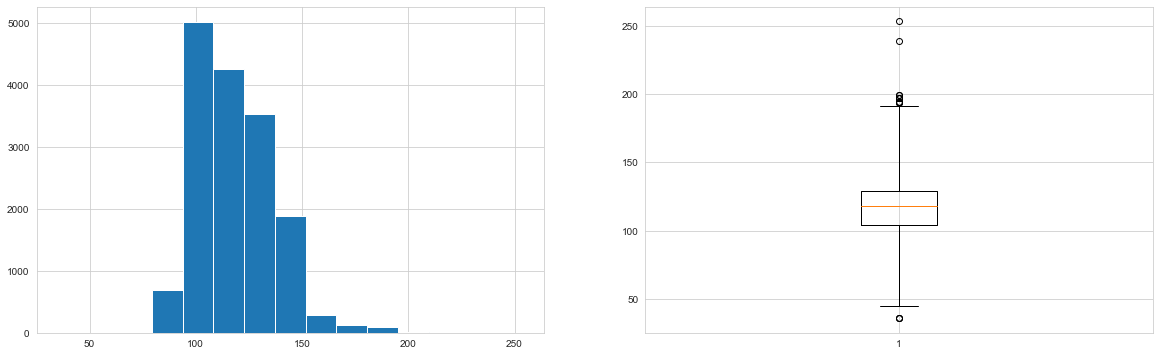

In [89]:
plt.figure(figsize=(20, 6))

plt.subplot(121)
plt.hist(df.CO2_Emission, bins=15)

plt.subplot(122)
plt.boxplot(df.CO2_Emission, whis=2.5)

plt.show()

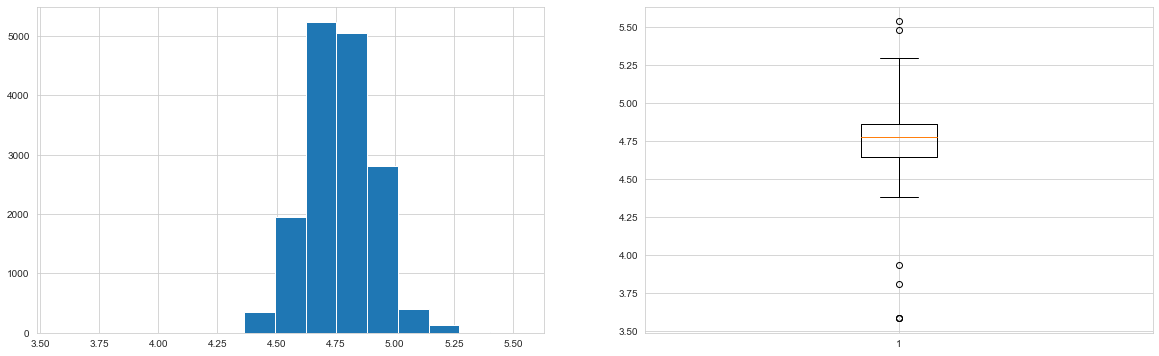

In [90]:
plt.figure(figsize = (20, 6))

plt.subplot(121)
plt.hist(np.log(df.CO2_Emission), bins=15)

plt.subplot(122)
plt.boxplot(np.log(df.CO2_Emission), whis=2.5)

plt.show()

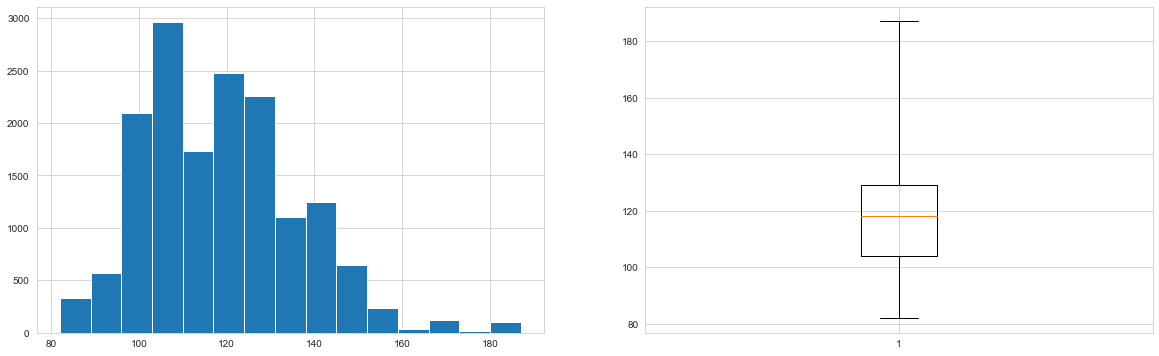

In [91]:
plt.figure(figsize = (20, 6))

plt.subplot(121)
plt.hist(winsorize(df.CO2_Emission, (0.001, 0.003)), bins = 15)

plt.subplot(122)
plt.boxplot(winsorize(df.CO2_Emission, (0.001, 0.003)), whis=2.5)

plt.show()

## cons_comb

In [92]:
first_looking("cons_comb")

column name    :  cons_comb
--------------------------------
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  62
--------------------------------
4.000    1020
5.600     965
5.400     900
5.000     810
4.700     766
3.900     733
4.500     731
4.400     668
5.100     657
3.800     585
4.800     580
4.200     579
4.900     535
5.300     530
5.200     454
4.600     426
5.500     389
5.900     369
3.700     369
4.100     362
5.700     342
6.000     331
3.300     307
4.300     307
3.500     288
3.600     231
6.200     219
6.300     181
6.100     175
5.800     165
6.600     148
6.800     136
3.400     125
6.400      75
3.000      69
7.400      66
6.500      43
6.700      43
7.100      38
6.900      27
3.200      25
8.300      20
3.650      20
3.450      19
5.150      19
7.600      14
7.000      10
3.100       7
7.800       6
7.200       6
8.000       5
8.600       4
3.950       3
7.900       3
8.700       3
7.300       2
8.100       2
5.450       2
4.550       2
9.100       1
4

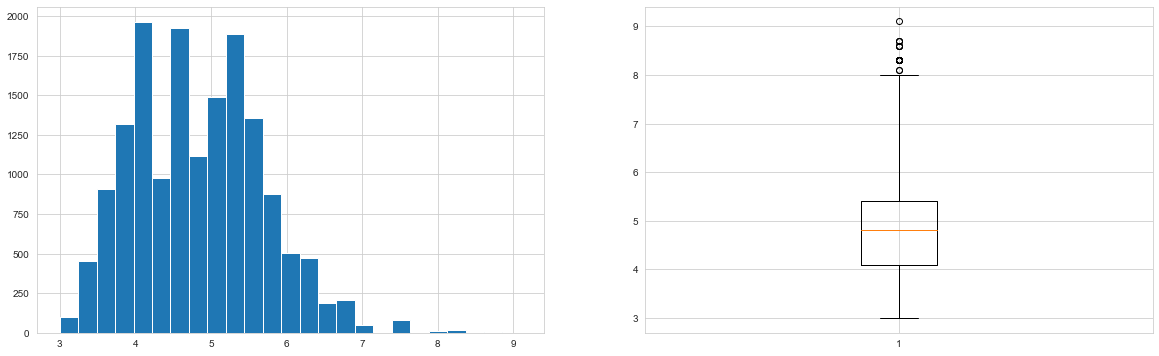

In [93]:
plt.figure(figsize = (20, 6))

plt.subplot(121)
plt.hist(df.cons_comb, bins = 25)

plt.subplot(122)
plt.boxplot(df.cons_comb, whis = 2)

plt.show()

In [94]:
df.cons_comb.describe()

count   15919.000
mean        4.832
std         0.868
min         3.000
25%         4.100
50%         4.800
75%         5.400
max         9.100
Name: cons_comb, dtype: float64

In [95]:
df.cons_comb.sort_values().head(10)

6440    3.000
2863    3.000
2862    3.000
13493   3.000
13482   3.000
11004   3.000
11015   3.000
11044   3.000
811     3.000
6240    3.000
Name: cons_comb, dtype: float64

In [96]:
df.cons_comb.sort_values().tail(10)

3601    8.300
3649    8.300
10789   8.600
12553   8.600
12530   8.600
12422   8.600
10817   8.700
12054   8.700
12529   8.700
10771   9.100
Name: cons_comb, dtype: float64

**Considering our domain knowledge, we can conclude that min value of 3 and max value of 9.10 are normal.**

## Nr_of_Doors

In [97]:
first_looking("Nr_of_Doors")

column name    :  Nr_of_Doors
--------------------------------
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  6
--------------------------------
5.000    11787
4.000     3079
3.000      832
2.000      219
1.000        1
7.000        1
Name: Nr_of_Doors, dtype: int64


In [98]:
df.Nr_of_Doors.replace([1, 7], np.nan, inplace=True)

In [99]:
df.Nr_of_Doors.isnull().sum()

2

In [100]:
fill(df, "make_model", "body_type", "Nr_of_Doors", "mode")

Number of NaN :  0
------------------
5.000    11789
4.000     3079
3.000      832
2.000      219
Name: Nr_of_Doors, dtype: int64


AttributeError: 'AxesSubplot' object has no attribute 'bar_label'

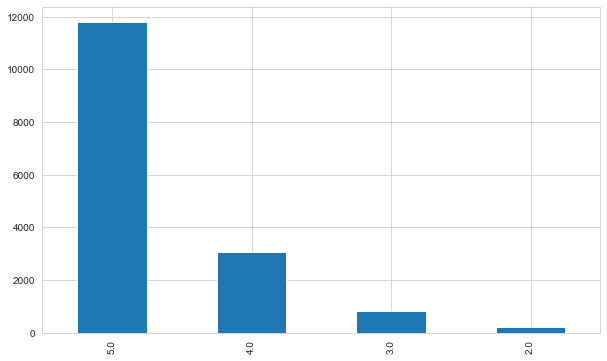

In [101]:
fig, ax = plt.subplots()

df.Nr_of_Doors.value_counts(dropna = False).plot.bar()

for container in ax.containers:
    ax.bar_label(container);

AttributeError: 'AxesSubplot' object has no attribute 'bar_label'

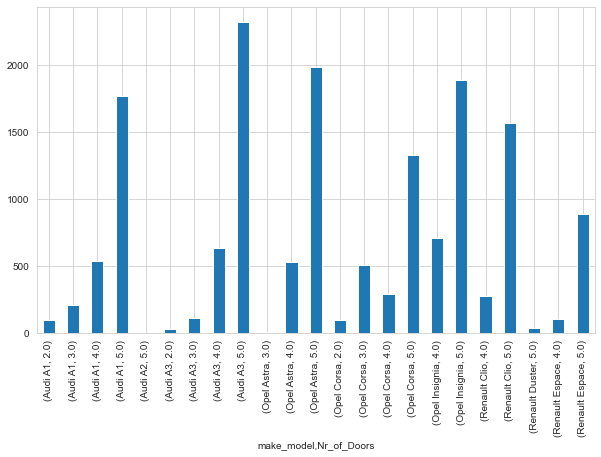

In [102]:
fig, ax = plt.subplots()

df.groupby(["make_model", "Nr_of_Doors"]).Nr_of_Doors.count().plot.bar()

for container in ax.containers:
    ax.bar_label(container);

In [74]:
df.drop("Nr_of_Doors", axis=1, inplace=True)

## Nr_of_Seats

In [103]:
first_looking("Nr_of_Seats")

column name    :  Nr_of_Seats
--------------------------------
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  6
--------------------------------
5.000    14308
4.000     1127
7.000      362
2.000      119
6.000        2
3.000        1
Name: Nr_of_Seats, dtype: int64


In [104]:
df.Nr_of_Seats.replace([3, 6], np.nan, inplace=True)

In [105]:
df.Nr_of_Seats.isnull().sum()

3

In [106]:
fill(df, "make_model", "body_type", "Nr_of_Seats", "mode")

Number of NaN :  0
------------------
5.000    14311
4.000     1127
7.000      362
2.000      119
Name: Nr_of_Seats, dtype: int64


AttributeError: 'AxesSubplot' object has no attribute 'bar_label'

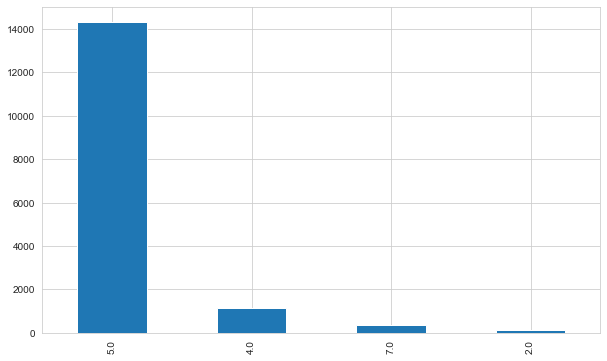

In [107]:
fig, ax = plt.subplots()

df.Nr_of_Seats.value_counts(dropna=False).plot.bar()

for container in ax.containers:
    ax.bar_label(container);

AttributeError: 'AxesSubplot' object has no attribute 'bar_label'

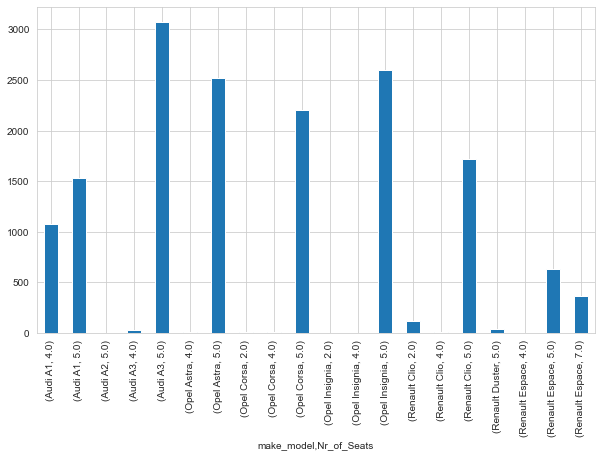

In [108]:
fig, ax = plt.subplots()

df.groupby(["make_model", "Nr_of_Seats"]).Nr_of_Seats.count().plot.bar()

for container in ax.containers:
    ax.bar_label(container);

In [109]:
df.drop("Nr_of_Seats", axis=1, inplace=True)

## price

In [110]:
first_looking("price")

column name    :  price
--------------------------------
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  2956
--------------------------------
14990    154
15990    151
10990    139
15900    106
17990    102
        ... 
17559      1
17560      1
17570      1
17575      1
39875      1
Name: price, Length: 2956, dtype: int64


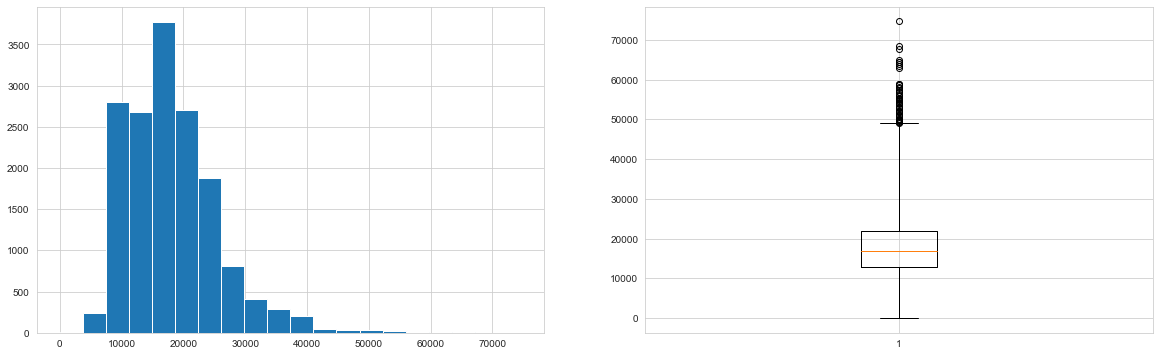

In [111]:
plt.figure(figsize=(20, 6))

plt.subplot(121)
plt.hist(df.price, bins=20)

plt.subplot(122)
plt.boxplot(df.price, whis=3)

plt.show()

In [112]:
df.price.describe()

count   15919.000
mean    18019.897
std      7386.169
min        13.000
25%     12850.000
50%     16900.000
75%     21900.000
max     74600.000
Name: price, dtype: float64

In [113]:
df.price.sort_values().head(5)

8594      13
8828     120
6066     255
8829     331
8827    4950
Name: price, dtype: int64

In [114]:
df.drop(index=[8594, 8828, 6066, 8829], axis=0, inplace=True)

In [115]:
df.reset_index(drop=True, inplace=True)

In [116]:
df.shape

(15915, 25)

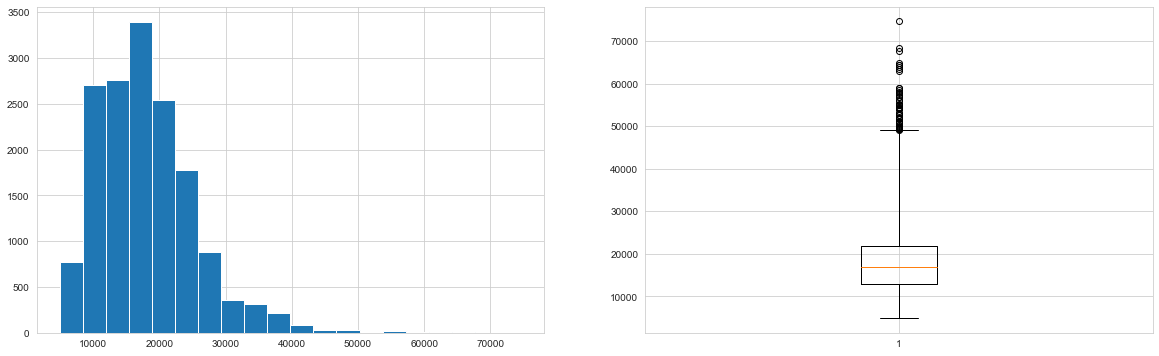

In [117]:
plt.figure(figsize=(20, 6))

plt.subplot(121)
plt.hist(df.price, bins=20)

plt.subplot(122)
plt.boxplot(df.price, whis=3)

plt.show()

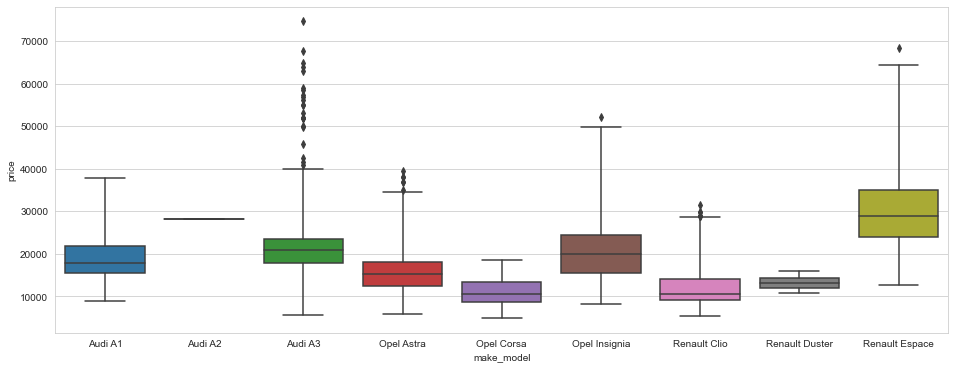

In [118]:
plt.figure(figsize=(16, 6))
sns.boxplot(x="make_model", y="price", data=df, whis=3)
plt.show()

## make_model

In [119]:
first_looking("make_model")

column name    :  make_model
--------------------------------
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  9
--------------------------------
Audi A3           3097
Audi A1           2614
Opel Insignia     2598
Opel Astra        2525
Opel Corsa        2216
Renault Clio      1839
Renault Espace     991
Renault Duster      34
Audi A2              1
Name: make_model, dtype: int64


In [120]:
df[df.make_model=="Audi A2"]

,make_model,body_type,price,vat,km,Type,Fuel,Comfort_Convenience,Entertainment_Media,Extras,Safety_Security,Gears,age,Previous_Owners,hp_kW,Inspection_new,Paint_Type,Upholstery_type,Nr_of_Doors,Gearing_Type,Displacement_cc,Weight_kg,Drive_chain,cons_comb,CO2_Emission
2614,Audi A2,Off-Road,28200,VAT deductible,26166.000,Employee's car,Diesel,"Air conditioning,Armrest,Automatic climate con...","Bluetooth,CD player,Hands-free equipment,MP3,O...",Alloy wheels,"ABS,Adaptive Cruise Control,Central door lock,...",6.000,1.000,1.000,85.000,0,Metallic,Cloth,5.000,Manual,1598.000,1135.000,front,4.900,118.000


The **``Audi A2``** (internally designated Typ 8Z) is a compact MPV-styled supermini car, with a five-door hatchback body style and four or five seats, produced by the German manufacturer Audi **from November 1999 (for the 2000 model year) to August 2005** [Source](https://en.wikipedia.org/wiki/Audi_A2). **So it is impossible to be a 1-year old Audi A2**.

In [121]:
df.drop(index=[2614], inplace=True)

In [122]:
df.reset_index(drop=True, inplace=True)

## Fuel

In [123]:
first_looking("Fuel")

column name    :  Fuel
--------------------------------
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  4
--------------------------------
Benzine     8548
Diesel      7297
LPG/CNG       64
Electric       5
Name: Fuel, dtype: int64


In [124]:
df[df.Fuel == "Electric"][["make_model", "body_type", "CO2_Emission", "Gears", "hp_kW", "cons_comb", "price"]]

,make_model,body_type,CO2_Emission,Gears,hp_kW,cons_comb,price
3355,Audi A3,Compact,107.000,6.000,150.000,4.100,24950
3611,Audi A3,Sedans,36.000,6.000,110.000,4.000,38450
3614,Audi A3,Sedans,36.000,6.000,110.000,4.000,35899
3616,Audi A3,Sedans,36.000,6.000,110.000,4.000,38000
13392,Renault Clio,Sedans,114.000,6.000,55.000,5.000,8490


## Final_Step

In [125]:
df.head(3).T

,0,1,2
make_model,Audi A1,Audi A1,Audi A1
body_type,Sedans,Sedans,Sedans
price,15770,14500,14640
vat,VAT deductible,Price negotiable,VAT deductible
km,56013.000,80000.000,83450.000
Type,Used,Used,Used
Fuel,Diesel,Benzine,Diesel
Comfort_Convenience,"Air conditioning,Armrest,Automatic climate con...","Air conditioning,Automatic climate control,Hil...","Air conditioning,Cruise control,Electrical sid..."
Entertainment_Media,"Bluetooth,Hands-free equipment,On-board comput...","Bluetooth,Hands-free equipment,On-board comput...","MP3,On-board computer"
Extras,"Alloy wheels,Catalytic Converter,Voice Control","Alloy wheels,Sport seats,Sport suspension,Voic...","Alloy wheels,Voice Control"


In [126]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15914 entries, 0 to 15913
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   make_model           15914 non-null  object 
 1   body_type            15914 non-null  object 
 2   price                15914 non-null  int64  
 3   vat                  15914 non-null  object 
 4   km                   15914 non-null  float64
 5   Type                 15914 non-null  object 
 6   Fuel                 15914 non-null  object 
 7   Comfort_Convenience  15914 non-null  object 
 8   Entertainment_Media  15914 non-null  object 
 9   Extras               15914 non-null  object 
 10  Safety_Security      15914 non-null  object 
 11  Gears                15914 non-null  float64
 12  age                  15914 non-null  float64
 13  Previous_Owners      15914 non-null  float64
 14  hp_kW                15914 non-null  float64
 15  Inspection_new       15914 non-null 

In [127]:
df_num = df.select_dtypes("number")
df_num

,price,km,Gears,age,Previous_Owners,hp_kW,Inspection_new,Nr_of_Doors,Displacement_cc,Weight_kg,cons_comb,CO2_Emission
0,15770,56013.000,7.000,3.000,2.000,66.000,1,5.000,1422.000,1220.000,3.800,99.000
1,14500,80000.000,7.000,2.000,1.000,141.000,0,3.000,1798.000,1255.000,5.600,129.000
2,14640,83450.000,7.000,3.000,1.000,85.000,0,4.000,1598.000,1135.000,3.800,99.000
3,14500,73000.000,6.000,3.000,1.000,66.000,0,3.000,1422.000,1195.000,3.800,99.000
4,16790,16200.000,7.000,3.000,1.000,66.000,1,5.000,1422.000,1135.000,4.100,109.000
...,...,...,...,...,...,...,...,...,...,...,...,...
15909,39950,1647.363,6.000,0.000,1.000,147.000,0,5.000,1997.000,1758.000,5.300,139.000
15910,39885,9900.000,7.000,0.000,1.000,165.000,0,5.000,1798.000,1708.000,7.400,168.000
15911,39875,15.000,6.000,0.000,1.000,146.000,1,5.000,1997.000,1734.000,5.300,139.000
15912,39700,10.000,6.000,0.000,1.000,147.000,0,5.000,1997.000,1758.000,5.300,139.000


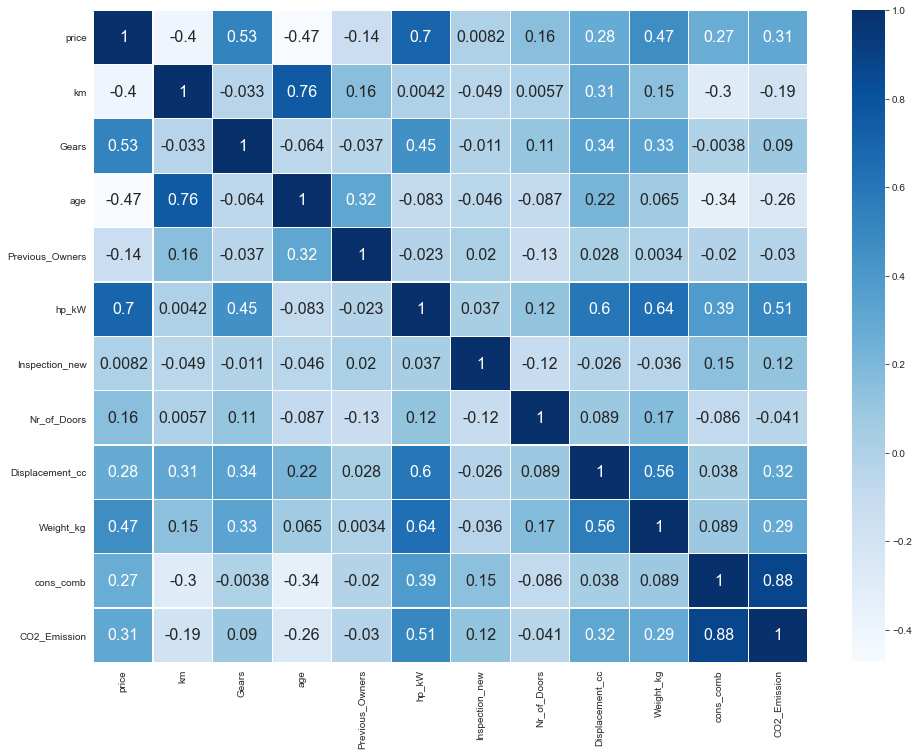

In [128]:
plt.figure(figsize=(16, 12))

sns.heatmap(df_num.corr(), annot=True, cmap="Blues", linewidths=0.2, annot_kws={"size": 16});

In [130]:
# function for set text color of correlation values in Dataframes

def color_correlation(val):
    """
    Takes a scalar and returns a string with
    the css property in a variety of color scales 
    for different correlations.
    """
    if val >= 0.6 and val < 0.99999 or val <= -0.6 and val > -0.99999:
        color = 'red'
    elif val < 0.6 and val >= 0.3 or val > -0.6 and val <= -0.3:
        color = 'blue'
    elif val == 1:
        color = 'cyan'    
    else:
        color = 'black'
    return 'color: %s' % color
 
df_num.corr().style.applymap(color_correlation)

,price,km,Gears,age,Previous_Owners,hp_kW,Inspection_new,Nr_of_Doors,Displacement_cc,Weight_kg,cons_comb,CO2_Emission
price,1.000000,-0.399301,0.530214,-0.473478,-0.144625,0.696465,0.008230,0.158929,0.281791,0.468564,0.272270,0.314104
km,-0.399301,1.000000,-0.033091,0.758306,0.157040,0.004216,-0.049449,0.005713,0.306784,0.147093,-0.300198,-0.186390
Gears,0.530214,-0.033091,1.000000,-0.064488,-0.036598,0.449574,-0.011042,0.113109,0.339428,0.333949,-0.003751,0.089624
age,-0.473478,0.758306,-0.064488,1.000000,0.316107,-0.083257,-0.045524,-0.086637,0.215283,0.064863,-0.341303,-0.259506
Previous_Owners,-0.144625,0.157040,-0.036598,0.316107,1.000000,-0.022557,0.019541,-0.133390,0.027964,0.003435,-0.020171,-0.029704
hp_kW,0.696465,0.004216,0.449574,-0.083257,-0.022557,1.000000,0.036603,0.120969,0.597498,0.638323,0.388913,0.507647
Inspection_new,0.008230,-0.049449,-0.011042,-0.045524,0.019541,0.036603,1.000000,-0.116848,-0.025961,-0.035555,0.147818,0.124233
Nr_of_Doors,0.158929,0.005713,0.113109,-0.086637,-0.133390,0.120969,-0.116848,1.000000,0.089488,0.174356,-0.085724,-0.041139
Displacement_cc,0.281791,0.306784,0.339428,0.215283,0.027964,0.597498,-0.025961,0.089488,1.000000,0.563440,0.037811,0.316925
Weight_kg,0.468564,0.147093,0.333949,0.064863,0.003435,0.638323,-0.035555,0.174356,0.563440,1.000000,0.088940,0.288976


In [131]:
#sns.pairplot(df_num, size=2.5);

## <p style="background-color:#9d4f8c; font-family:newtimeroman; color:#FFF9ED; font-size:175%; text-align:center; border-radius:10px 10px;">Dummy Operation</p>

<a id="3"></a>
<a href="#toc" class="btn btn-primary btn-sm" role="button" aria-pressed="true" 
style="color:blue; background-color:#dfa8e4" data-toggle="popover">Content</a>

In [132]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15914 entries, 0 to 15913
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   make_model           15914 non-null  object 
 1   body_type            15914 non-null  object 
 2   price                15914 non-null  int64  
 3   vat                  15914 non-null  object 
 4   km                   15914 non-null  float64
 5   Type                 15914 non-null  object 
 6   Fuel                 15914 non-null  object 
 7   Comfort_Convenience  15914 non-null  object 
 8   Entertainment_Media  15914 non-null  object 
 9   Extras               15914 non-null  object 
 10  Safety_Security      15914 non-null  object 
 11  Gears                15914 non-null  float64
 12  age                  15914 non-null  float64
 13  Previous_Owners      15914 non-null  float64
 14  hp_kW                15914 non-null  float64
 15  Inspection_new       15914 non-null 

In [133]:
df.shape

(15914, 25)

In [134]:
df.to_csv("final_scout_not_dummy.csv", index=False)

In [135]:
df = df.join(df["Comfort_Convenience"].str.get_dummies(sep=",").add_prefix("cc_"))
df = df.join(df["Entertainment_Media"].str.get_dummies(sep=",").add_prefix("em_"))
df = df.join(df["Extras"].str.get_dummies(sep = ",").add_prefix("ex_"))
df = df.join(df["Safety_Security"].str.get_dummies(sep=",").add_prefix("ss_"))

In [136]:
df.drop(["Comfort_Convenience", "Entertainment_Media", "Extras", "Safety_Security"], axis=1, inplace=True)

In [137]:
df.shape

(15914, 115)

In [138]:
df_final = pd.get_dummies(df, drop_first=True)

In [139]:
df_final.shape

(15914, 135)

In [140]:
df_final.head().T

,0,1,2,3,4
price,15770.000,14500.000,14640.000,14500.000,16790.000
km,56013.000,80000.000,83450.000,73000.000,16200.000
Gears,7.000,7.000,7.000,6.000,7.000
age,3.000,2.000,3.000,3.000,3.000
Previous_Owners,2.000,1.000,1.000,1.000,1.000
hp_kW,66.000,141.000,85.000,66.000,66.000
Inspection_new,1.000,0.000,0.000,0.000,1.000
Nr_of_Doors,5.000,3.000,4.000,3.000,5.000
Displacement_cc,1422.000,1798.000,1598.000,1422.000,1422.000
Weight_kg,1220.000,1255.000,1135.000,1195.000,1135.000


In [141]:
df_final.to_csv("final_scout_dummy.csv", index=False)

## <p style="background-color:#FDFEFE; font-family:newtimeroman; color:#9d4f8c; font-size:150%; text-align:center; border-radius:10px 10px;">The End of Handling with Outliers (Part - 03)</p>

<a id="4"></a>
<a href="#toc" class="btn btn-primary btn-sm" role="button" aria-pressed="true" 
style="color:blue; background-color:#dfa8e4" data-toggle="popover">Content</a>